# Analyzing the NYC Subway Dataset

Craig Nicholson
September 9th 2015

In this notebook, we will review look the NYC Subway data and determine if more people ride the subway when it is raining versus when it is not raining.

## Imports

In [359]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import SGDRegressor

In [360]:
# display plot within the notebook rather than a new window
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Load the Data

In [361]:
# load the stroopdata.csv
path = '~/Downloads/P2-1/turnstile_weather_v2.csv'
df = pd.read_csv(path)

In [362]:
# fetch two samples, the one with rain and the one without rain
# 1 = rain, 0 = no rain for the entry
# reset the indexes since we have new dataframes
rain = df[df['rain']==1].reset_index()
norain =  df[df['rain']==0].reset_index()

## Section 1. Statistical Test

#### null Hypothesis
The number of hourly entries is the same for rainy vs no rain days.  

H0: μd = μ0
#### Alternate Hypothesis
The is a difference between the number of hourly entries for rainy and no rain days.  

HA: μd ≠ μ0
#### Statistical Test
Since we have one large sample and are reviewing riders on the days it is raining vs. not raining we will run an Independant T-test.

#### Independant variables
Rain vs No Rain
#### Dependent variable
The number of ENTRIESn_hourly

## Calculations

In [363]:
'''
 The Mann-Whitney U test is used to compare differences between two independent groups 
 when the dependent variable is either ordinal or continuous, but not normally distributed. 
 
 Returns The Mann-Whitney statistics, p-value (one sided)
 Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U
 
 Hard to figure out U critical value
 http://www.real-statistics.com/statistics-tables/mann-whitney-table/
 http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Nonparametric/BS704_Nonparametric4.html
 
 Mann-Whitney U test can be applied on unknown distributions contrary to t-test which has to be applied 
 only on normal distributions, and it is nearly as efficient as the t-test on normal distributions.
 
 https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
'''
u_statistic, mannwhitney_p_value = stats.mannwhitneyu(rain['ENTRIESn_hourly'], norain['ENTRIESn_hourly']
                                                      , use_continuity=True)
print 'Mann-Whitney U test \nU statistic: %.3f \np-value (1 sided): %.9f\np-value (2-sided): %.9f' % (u_statistic, mannwhitney_p_value, 2*mannwhitney_p_value)

Mann-Whitney U test 
U statistic: 153635120.500 
p-value (1 sided): 0.000002741
p-value (2-sided): 0.000005482


In [364]:
'''
 t-test via scipy
 returns t-statistic and two-tailed p-value
 equal_var = False, perform Welch’s t-test, which does not assume equal population 
 Welch does not assume equal sample size or equal variances
 equal_var = True - returns 5.33
'''
t_test_results = stats.ttest_ind(rain['ENTRIESn_hourly'],norain['ENTRIESn_hourly']
                                 ,equal_var = False)
t_statistic = t_test_results[0]
p_value = t_test_results[1]
print'Welch''s T-test (Independent T-test) equal_var=False\nT-statistic: %.3f\tp-value: %.8f' % (t_statistic, p_value)

Welchs T-test (Independent T-test) equal_var=False
T-statistic: 5.043	p-value: 0.00000046


In [365]:
''' 
 Perform Levene test for equal variances.
 http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
 
 The Levene test tests the null hypothesis that all input samples are from populations 
 with equal variances. 
 
 Levene’s test is an alternative to Bartlett’s test bartlett in the case where there 
 are significant deviations from normality.
 
 Three variations of Levene’s test are possible. The possibilities and their recommended usages are:
    ‘median’ : Recommended for skewed (non-normal) distributions>
    ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
    ‘trimmed’ : Recommended for heavy-tailed distributions.
    
'''
w, levene_p_value = stats.levene(rain['ENTRIESn_hourly'], norain['ENTRIESn_hourly'] ,center='trimmed')
print 'Levene test for equal variances\nW statistic: %.3f \tp-value: %.9f' % (w, levene_p_value)

Levene test for equal variances
W statistic: 103.813 	p-value: 0.000000000


In [366]:
# Get the (n) number of samples in the rain and norain samples
rain_n = rain['UNIT'].count() 
norain_n = norain['UNIT'].count() 

# Get the (df) number of samples in each 
# We are using the independent t test 
rain_df = rain_n-1
norain_df = norain_n-1
pooled_df = rain_df+norain_df

In [367]:
# Get the means and medians for the rain
rain_xbar= rain['ENTRIESn_hourly'].mean()
rain_median = rain['ENTRIESn_hourly'].median()

# Get the means and medians for the norain
norain_xbar = norain['ENTRIESn_hourly'].mean()
norain_median = norain['ENTRIESn_hourly'].median()

In [368]:
# Get the standard deviations of the samples
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
rain_sd = stats.tstd(rain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))
norain_sd = stats.tstd(norain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))

# Standard Error of the Mean
# Run this calculations myself and validate the independant test
rain_se = stats.sem(rain['ENTRIESn_hourly'], axis=None, ddof=rain_df)
norain_se = stats.sem(norain['ENTRIESn_hourly'], axis=None, ddof=norain_df)
print 'Rain SE: %.2f\tNo Rain SE: %.2f' % (rain_se, norain_se)

Rain SE: 3189.27	No Rain SE: 2878.73


In [369]:
# Calculate the t-critical value, instead of using a table - woohoo
# http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.t.html
# By adding 1 to 0.95 and then dividing by 2, we get the critical value for 2 tail test
degrees_of_freedom = pooled_df
#critical_value = stats.t._ppf((1+0.95)/2., degrees_of_freedom)
critical_value = stats.t._ppf((1+0.99)/2., degrees_of_freedom)

In [370]:
# Calculate Sum of Squares (SS for rain), pooled var, pooled SE
# (X1 - XBar)**2
rain_SS = np.sum((rain['ENTRIESn_hourly']-rain_xbar)**2)
norain_SS = np.sum((norain['ENTRIESn_hourly']-norain_xbar)**2)

print 'Rain SS: %.2f\tNo Rain SS: %.2f' % (rain_SS, norain_SS)

Rain SS: 97493098540.65	No Rain SS: 274003713900.57


In [371]:
# Validate the above equation for rain
rain['dff_mean_var']  = rain['ENTRIESn_hourly']-rain_xbar
rain['SS'] = np.square(rain['dff_mean_var'])

# Validate the above equation for no rain
norain['dff_mean_var']  = norain['ENTRIESn_hourly']-norain_xbar
norain['SS'] = np.square(norain['dff_mean_var'])
print  rain['SS'].sum(), norain['SS'].sum()

# Calculate the Standard Error for each for checking scipy and learning std error
print np.sqrt(rain['SS'].sum()/rain_df), np.sqrt(norain['SS'].sum()/norain_df)

97493098540.7 2.74003713901e+11
3189.43337288 2878.77084798


In [372]:
# Pooled Varience is the Total of the Sum of Squares  / Total df
pooled_varience = (rain_SS+norain_SS)/(pooled_df)
print 'Pooled Varience: %.2f' % pooled_varience

Pooled Varience: 8710971.76


In [373]:
# Corrected Standard Error is the Total of the Sum of Squares  / Total Degrees of freedom
# SE Corrected with pooled var
# divide by n- sample size not df.
# the standard error is never negative
# Pooled Variance Sum of Squares has some corrections it uses the df instead of the sample sizes
pooled_SE = np.sqrt(pooled_varience/rain_n + pooled_varience/norain_n)
print 'Pooled SE: %.2f' % pooled_SE

Pooled SE: 34.24


In [374]:
# calculate the t-statistic, pooled
t_stat_check = (rain_xbar-norain_xbar)/pooled_SE
print 't_stat_check equal_var=True: %.3f' % t_stat_check

# Welch's t-test
t_stat_check =  (rain_xbar-norain_xbar)/ np.sqrt((np.square(rain_sd)/rain_n) + (np.square(norain_sd)/norain_n))
print 't_stat_check equal_var=True: %.3f' % t_stat_check

t_stat_check equal_var=True: 5.335
t_stat_check equal_var=True: 5.043


In [375]:
# r squared
r_squared = ( np.square(t_statistic) /  (np.square(t_statistic) + (degrees_of_freedom)  ))

In [376]:
# Cohens D
cohens_d = (rain_xbar-norain_xbar)/pooled_varience

In [377]:
# Calculate Confidence Intervals Independent Samples
# SE +/- (t_critical * SE) 
# https://www.udacity.com/course/viewer#!/c-ud134-nd/l-4576163829/e-154863542/m-154863544
lower_CI = (rain_xbar-norain_xbar)-(critical_value*pooled_SE)
upper_CI = (rain_xbar-norain_xbar)+(critical_value*pooled_SE)

### 1.1 Which statistical test did you use to analyze the NYC subway data? 
There are 3 tests which are applicable to this dataset.

- Welch's t-test
- Mann Whitney u-test
- Independent t-test


#### Welch's t-test
> Welch's t-test is more robust than Student's t-test and maintains type I error rates close to nominal for unequal variances and for unequal sample sizes. Furthermore, the power of Welch's t-test comes close to that of Student’s t-test, even when the population variances are equal and sample sizes are balanced.[2]

> It is not recommended to pre-test for equal variances and then choose between Student's t-test or Welch's t-test.[4] Rather, Welch's t-test can be applied directly and without any substantial disadvantages to Student's t-test as noted above. Welch's t-test remains robust for skewed distributions and large sample sizes.[5] Reliability decreases for skewed distributions and smaller samples, where one could possibly perform Welch’s t-test on ranked data.[3]

Welch's t test, Wikipedia  
Retrieved From: https://en.wikipedia.org/wiki/Welch%27s_t_test


####  Mann Whitney U-test

Additionally, I also ran the Mann Whitney U-test after reviewing the assumptions for the indendendent-samples t-test.


#### Independent t-test
(independent samples t-test) compares the means between two unrelated groups on the same continuous, dependent variable.

The independent t-test, also called the two sample t-test or student's t-test, is an inferential statistical test that determines whether there is a statistically significant difference between the means in two unrelated groups.

The Independent T-test failed several assumptions.  However, the Independent T-test was robust enought to provide reasonable results for review.

#### Did you use a one-tail or a two-tail P value?
A two-tail test is used to analze the data.

#### What is the null hypothesis?   
There is no difference in hourly entries for rainy and non rainy days:

H0: u1 = u2

#### What is the alternative hypothesis?
There is a difference between hourly entries on rain and no rain days.

HA: u1 ≠ u2  




#### What is your p-critical value?
99%, Significance Level: alpha 	 = 0.01 , two tail test    
p critical is 0.005  

t-critical is +/- 2.576   



### 1.2 Why is this statistical test applicable to the dataset?

- Mann Whitney U Test
The Mann-Whitney U test is used to compare differences between two independent groups 
when the dependent variable is either ordinal or continuous, but not normally distributed.

- Welch's T-Test (Independent T-Test)
We have two unrelated groups on the same continuous, dependent variable, with different sample sizes.

*Note: Welch's T-Test does not assume equal sample size or equal variances.*



####  In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.


##### Assumption of normality of the dependent variable
The **independent t-test** requires that the dependent variable is approximately normally distributed **within each group**. We can test for this using a multitude of tests, but the Shapiro-Wilks Test or a graphical method, such as a Q-Q Plot, are common. 

However, the t-test is described as a robust test with respect to the assumption of normality. This means that even deviations away from normality do not have a large influence on Type I error rates. The exception to this is if the difference in the size of the groups is greater than 1.5 (largest compared to smallest).

##### What to do when you violate the normality assumption:
Run the Mann-Whitney U Test which is a non-parametric test that does not require the assumption of normality.

Mann-Whitney U test  
u statistic: 153,635,120 	p-value: 0.000

Our p-value <  0.005 (p-critical)


##### Assumption of Homogeneity of Variance
The independent t-test assumes the variances of the two groups you are measuring to be equal. 

To test the Homogeneity of Variance we use Levene's Test for Equality of Variances'.

> If your variances are unequal, this can affect the Type I error rate. The assumption of homogeneity of variance can be tested using Levene's Test of Equality of Variances.

> This test for homogeneity of variance provides an F statistic and a significance value (p-value). We are primarily concerned with the significance level - if it is greater than 0.05, our group variances can be treated as equal. However, if p < 0.05, we have unequal variances and we have violated the assumption of homogeneity of variance.

Levene test for equal variances  
W statistic: 103.813  	
p-value: 0.000  

We have violated the assumption of equal variances.  We have unequal variances.

##### Overcoming a Violation of the Assumption of Homogeneity of Variance

> If the Levene's Test for Equality of Variances is statistically significant, and therefore indicates unequal variances, we can correct for this violation by not using the pooled estimate for the error term for the t-statistic, and also making adjustments to the degrees of freedom using the Welch-Satterthwaite method. 

Welch's T-Test does not assume equal sample size or equal variances.

#### Results
    - Rain sample is 3.44 times smaller than the no rain sample
    - Q-Q Plots show a non-normal distribution
    - Shapiro-Wilks Test for normal distribution: reports the disributrion is not normal (p-value < 0.05)
    - We do not have a normal distribution.  
    - Levene test for equal variances is violated
    - We should use Mann Whitney for the statistical analysis
    - Welch's t-test would be a second choice


#### References 
Independent T-Test for Two Samples, Laerd Statistics Blog  
Retreived From https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Mann Whitney U-Test, Laerd Statistics Blog  
Retreived From https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php

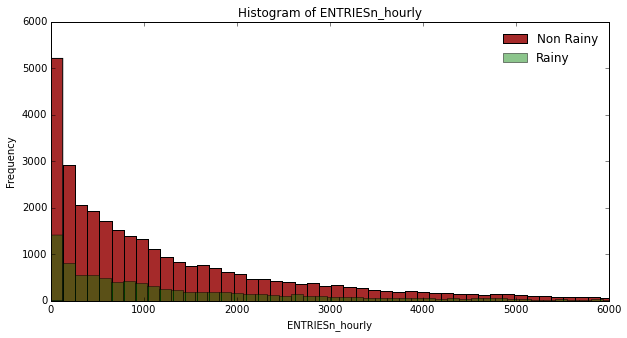

In [379]:
# Histogram - These plots have the same shape - and they are not normally distributed
plt.hist(norain['ENTRIESn_hourly'], bins=250, label='Non Rainy',color='brown')
plt.hist(rain['ENTRIESn_hourly'], bins=250, alpha=0.45, label='Rainy',color='green')
plt.title(r'Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.legend(loc='best', frameon=False)
# resize to show the distribution of the data
plt.axis(xmin=0, xmax=6000)
plt.figure(figsize(10,5))


The above plot demonstrates we have similar shapes in a non-normal distribution.

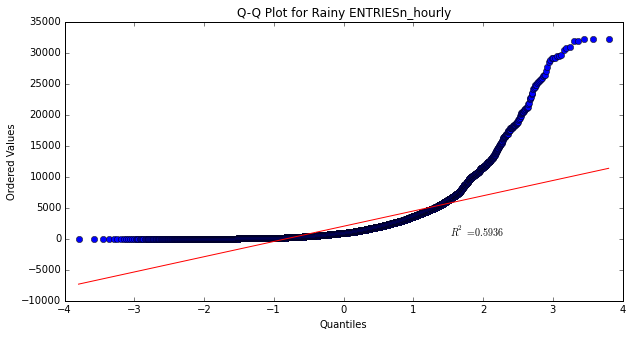

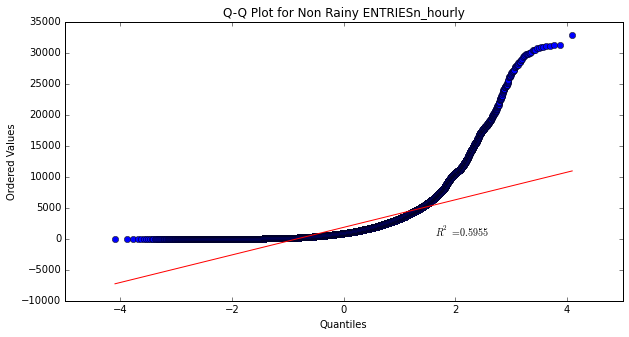

In [25]:
# Q-Q plot to test for normal distribution
# http://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy
stats.probplot(rain['ENTRIESn_hourly'], dist="norm", plot=pylab)
pylab.title('Q-Q Plot for Rainy ENTRIESn_hourly')
pylab.show()

stats.probplot(norain['ENTRIESn_hourly'], dist="norm", plot=pylab)
pylab.title('Q-Q Plot for Non Rainy ENTRIESn_hourly')
pylab.show()

The Q-Q plots demonstrate the non-normal distribution.  We have a large upward treend which occur to the right, around 2+ standard deviations.

In [242]:
'''
 Shapiro-Wilks Test for normal distribution
 scipy.stats.shapiro(x, a=None, reta=False)[source]¶
 http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm
 Returns:
 W : The test statistic.
 p-value : The p-value for the hypothesis test.
 a : array_like, optional
 
 The null-hypothesis of this test is that the population is normally distributed. 
 
 Thus if the p-value is less than the chosen alpha level, then the null hypothesis is 
 rejected and there is evidence that the data tested are not 
 from a normally distributed population. 
 
 In other words, the data are not normal. 
 
 On the contrary, if the p-value is greater than the chosen alpha level, 
 then the null hypothesis that the data came from a normally distributed 
 population cannot be rejected. 
 
 E.g. for an alpha level of 0.05, a data set with a p-value of 0.02 rejects 
 the null hypothesis that the data are from a normally distributed population.
 
 However, since the test is biased by sample size,[3] the test may be statistically 
 significant from a normal distribution in any large samples. 
 
 Thus a Q–Q plot is required for verification in addition to the test.
 
 Reference: https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
 
'''
sharipo_results = stats.shapiro(df['ENTRIESn_hourly'], a=None, reta=True)
print 'W Statistic %.3f \np-value: %.3f' % (sharipo_results[0], sharipo_results[1])
print 'The data tested are not from a normally distributed population'

W Statistic 0.594 
p-value: 0.000
The data tested are not from a normally distributed population


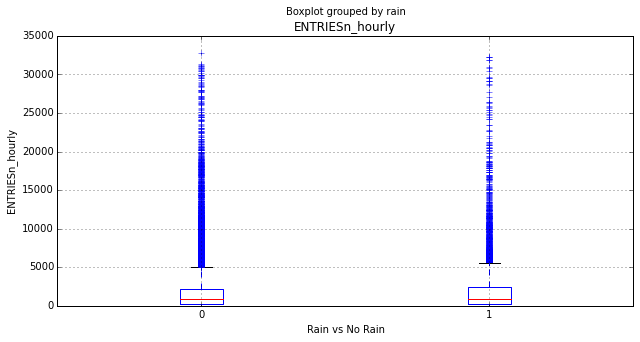

In [380]:
# Check for outliers
x_sec = df[['rain', 'ENTRIESn_hourly']]
plt.figure()
bp = x_sec.boxplot(by='rain')
plt.xlabel("Rain vs No Rain")
plt.ylabel("ENTRIESn_hourly")

### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

Mann Whitney and Welch's T-Test were both performed and Mann Whitney U Test was chosen over the Wlech's T-test based on the required assumptions needed for the Welch's T-test.

In [243]:
print '\n'
print 'TABLE 1.0 - MANN WHITNEY U-Test'
print '\n'
print 'DESCRIPTIVE STATISTICS'
print '\t\tn \t\tmean \t\tmedian \t\tStDev \t\tSE Mean'
print 'Rain   \t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (rain_n,rain_xbar, rain_median,rain_sd,rain_se)
print 'No Rain\t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (norain_n,norain_xbar,norain_median,norain_sd,norain_se)
print '\n'

print 'INFERENTIAL STATISTICS'
# Paired t-test, two tail, t-statistic ,df,p-value, direction of test (two tail, or one tail to in _/- directrion')
print 'Type of test\t\t\t = %s' % 'Mann Whitney u-test'
print 'Test statistics: U \t\t = %.5f' % u_statistic
print 'Degrees of Freedom\t\t = %.0f' % ((rain_n+norain_n)-2)
print 'Significance Level: alpha \t = %s ' % '0.01'
#print 'Critical value: t1-α/2,ν \t = %.3f' % critical_value
#print 'Critical region: Reject H0 if \t = |T| > %.3f' % critical_value
print 'P-Value\t\t\t\t = %.9f' % (mannwhitney_p_value*2)
print 'Direction of test\t\t = %s ' % 'two tail'
print '\n'



TABLE 1.0 - MANN WHITNEY U-Test


DESCRIPTIVE STATISTICS
		n 		mean 		median 		StDev 		SE Mean
Rain   		9585.00 	2028.20 	939.00 		3189.43 	3189.27
No Rain		33064.00 	1845.54 	893.00 		2878.77 	2878.73


INFERENTIAL STATISTICS
Type of test			 = Mann Whitney u-test
Test statistics: U 		 = 153635120.50000
Degrees of Freedom		 = 42647
Significance Level: alpha 	 = 0.01 
P-Value				 = 0.000005482
Direction of test		 = two tail 




In [391]:
print '\n'
print 'TABLE 2.0 - Welch''s T-Test'
print '\n'
print 'DESCRIPTIVE STATISTICS'
print '\t\tn \t\tmean \t\tmedian \t\tStDev \t\tSE Mean'
print 'Rain   \t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (rain_n,rain_xbar, rain_median,rain_sd,rain_se)
print 'No Rain\t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (norain_n,norain_xbar,norain_median,norain_sd,norain_se)
print '\n'
#print 'Pooled Varience: \t\t%.0f' % pooled_varience
#print 'Corrected Standard Error: \t%.3f' % pooled_SE
print '\n'

print 'INFERENTIAL STATISTICS'
# Paired t-test, two tail, t-statistic ,df,p-value, direction of test (two tail, or one tail to in _/- directrion')
print 'Type of test\t\t\t = %s' % 'Welch''s t-test'
print 'Test statistics: T \t\t = %.5f' % t_statistic
print 'Degrees of Freedom\t\t = %.0f' % ((rain_n+norain_n)-2)
print 'Significance Level: alpha \t = %s ' % '0.01'
print 'Critical value: t1-α/2,ν \t = %.3f' % critical_value
print 'Critical region: Reject H0 if \t = |T| > %.3f' % critical_value
print 'P-Value\t\t\t\t = %.9f' % p_value
print 'Direction of test\t\t = %s ' % 'two tail'
print '\n'

print 'CONFIDENCE INTERVALS'
print '99%% CI for the mean difference: (%.5f, %.5f)' % (lower_CI,upper_CI)
print 'Margin of Error: %.2f' % ((upper_CI-lower_CI)/2.0)
print '\n'

print 'EFFECT SIZE MEASURES'
print 'r squared \t\t\t = %.5f' % r_squared 
print 'Cohens-D\t\t\t = %.5f' % cohens_d



TABLE 2.0 - Welchs T-Test


DESCRIPTIVE STATISTICS
		n 		mean 		median 		StDev 		SE Mean
Rain   		9585.00 	2028.20 	939.00 		3189.43 	3189.27
No Rain		33064.00 	1845.54 	893.00 		2878.77 	2878.73




INFERENTIAL STATISTICS
Type of test			 = Welchs t-test
Test statistics: T 		 = 5.04288
Degrees of Freedom		 = 42647
Significance Level: alpha 	 = 0.01 
Critical value: t1-α/2,ν 	 = 2.576
Critical region: Reject H0 if 	 = |T| > 2.576
P-Value				 = 0.000000464
Direction of test		 = two tail 


CONFIDENCE INTERVALS
99% CI for the mean difference: (94.46027, 270.85292)
Margin of Error: 88.20


EFFECT SIZE MEASURES
r squared 			 = 0.00060
Cohens-D			 = 0.00002


### 1.4 What is the significance and interpretation of these results?


### Mann Whitney U Test

We can reject the null hypothesis.  H0: u1 = u2


### Welch's T-Test
We Reject the null hypothesis based on the t-test results.

An Welch's t-test was run on the data as well as 99% confidence intervals (CI) for the mean difference. It was found during days with rain, the ENTRIESn_hourly (2028.20  ± 3189.43) were significantly higher than the days with No Rain (1845.54 ± 2878.77). 

t(42647) = 5.043, p < 0.005) with a difference of 182.66 (99% CI, 94.46 to 270.85) ENTRIESn_hourly.

## Section 2. Linear Regression


### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: OLS using Statsmodels or Scikit Learn Gradient descent using Scikit Learn Or something different?

The OLS method from Statsmodels is used to compute the coefficients that and produce predictions for the ENTRIES_hourly.

In [386]:
values  = df['ENTRIESn_hourly']
features = df[["precipi","rain","hour","wspdi", "fog","tempi","pressurei"]]

dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(dummy_units)

dummy_units = pd.get_dummies(df['conds'], prefix='conds')
features = features.join(dummy_units)

dummy_units = pd.get_dummies(df['day_week'], prefix='dow')
features = features.join(dummy_units)

#dummy_units = pd.get_dummies(df['station'], prefix='station')
#features = features.join(dummy_units)
Y = values
X = features
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
intercept =  results.params[0]
params = results.params

intercept, params

print results.summary()
predictions = intercept + np.dot(features, params[1:])

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     153.9
Date:                Mon, 14 Sep 2015   Prob (F-statistic):               0.00
Time:                        20:24:43   Log-Likelihood:            -3.8700e+05
No. Observations:               42649   AIC:                         7.745e+05
Df Residuals:                   42385   BIC:                         7.768e+05
Df Model:                         263                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                   8285

### 2.2 What features (input variables) did you use in your model? 

In [266]:
results.params[:8]

const        8285.209460
precipi     -1371.611180
rain           37.875636
hour          119.153812
wspdi          17.431536
fog          -371.974689
tempi           2.701452
pressurei    -326.181030
dtype: float64

### Did you use any dummy variables as part of your features? 
Yes:
- UNIT
- conds
- day_week

A dummy variable is a categorical variable [in one column] which is converted into dummy/indicator variables.  What we do is transform or pivot the categorical variable from one column into many columns and the value in the column is either a 1 or 0 to inidicate if a row from this sample contains this dummy/indicator variable.

Hourly entries are associated to a turnstyle which can be located in a heavy populated area to a less populated area of New York.  Units in highly populated areas will be more popular, have more hourly entries than other units. 

Using the turnstyles as dummy variables one is able to make better predications.

Conditions were used as dummy variables as well as day of the week (M,T,W,Th, F, Sat, Sun) since rainy days are typically cloudy or another condition and weekend ridership is less on the weekends than weekdays.

**Example Conditions Coefficients:**  
conds_Clear: 695.0809   
conds_Fog: 1162.0372   
conds_Mist: 1406.2281    

**Example Day of the weekCoefficients:**   
dow_0: 1099.0852     
dow_1: 1450.2563   
dow_2: 1553.0466   
dow_3: 1594.1534   
dow_4: 1558.3367   
dow_5:  653.5154   
dow_6: 376.8159  
(0:N, 1:T, 2:W, 3:TH, 4:F, 5:S, 6:S)

Weekend days have a smaller coefficient.


**Example UNIT Dummy Variables:**  

unit_R012 is positive coefficeint while unit_R008 has a negative coefficent.
When unit_R012 is set to 1, meaning this row of data is at this turnstyle, we will add 6856 to the linear equation and the hourly entries.   The opposite will occur with unit_R008, we will subtract -1424 hourly entries when the row of data has a 1 value in the unit_R008 column's value.

Less popular stations/Units have a smaller or even negative coefficient.

In [233]:
results.params[12:20]

unit_R008   -1424.593808
unit_R009   -1476.659377
unit_R011    5517.035648
unit_R012    6856.766505
unit_R013     755.207365
unit_R016   -1054.411219
unit_R017    2370.201988
unit_R018    6006.404425
dtype: float64


### 2.3 Why did you select these features in your model? 

*We are looking for specific reasons that lead you to believe that the selected features will contribute to the predictive power of your model. Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.” Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”*

I reviewed the data and would remove and add features one at a time and observe the r-squared result and the residual plots.

Rain and meanprecipi were used because we are looking for the trend that rain causes more hourly entries and rain and the amount (average) rain during a time period can influcnce a person to ride the subway.   A light rain or sprinkle might also lead to more people riding the subway.

People ride the subway during all hours of the day but we have spikes in the morning and afternoon due to people commuting to New York so hour was used as part of the feature selection.

Ridership on the subway declines on the weekends therefore it is important to have the day of the week in the feature set so we can get more accurate predications since a weekday or 0 to 6 would have a coefficient.

*One could code up all the posibilitys of the features and run them all through the OLS and sort by r-squared desecending to find the optimal solution for this dataset.*


### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model? 

In [265]:
results.params[:8]

const        8285.209460
precipi     -1371.611180
rain           37.875636
hour          119.153812
wspdi          17.431536
fog          -371.974689
tempi           2.701452
pressurei    -326.181030
dtype: float64

### 2.5 What is your model’s R2 (coefficients of determination) value?

In [417]:
# Validate the results from OLS, and just for myself to learn R-Square
SST = ((df['ENTRIESn_hourly']-np.mean(df['ENTRIESn_hourly']))**2).sum()
SSReg = ((predictions-df['ENTRIESn_hourly'])**2).sum()
r_squared = 1 - (SSReg/SST)
print 'Validate R-Squared: \t%.3f' % r_squared

print 'OLS Models R-Squared: \t%.3f' % results.rsquared

Validate R-Squared: 	0.489
OLS Models R-Squared: 	0.489


### 2.6 What does this R2 value mean for the goodness of fit for your regression model?
The R2 shows this model needs improvement. 


###  Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?

Our model is appropriate and has room for improvement and/or is missing a feature (review the Predications vs Actual, and Predications vs Residuals) or the different population density areas need to be grouped into different datasets or samples.

The Q-Q plot shows a more polynominal relationship of the data and we might adjust our linear regression to support this dataset

#### Residual Plot - Histogram

The following residuals plot is useful evidence for the linear regression model being appropriate. The distribution  looks reasonably symmetric.

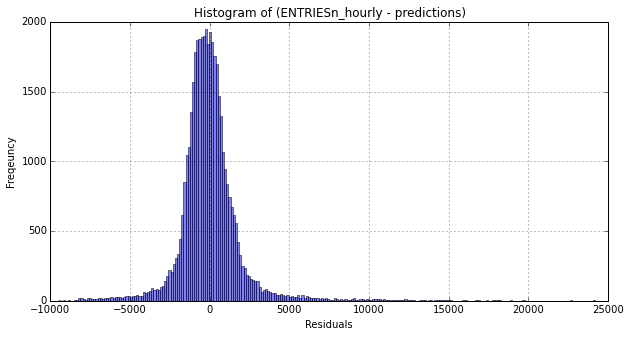

In [393]:
residuals = df['ENTRIESn_hourly'] - predictions 
# how can I be sure the dataframe and predications line up on the correct row
plt.figure()
residuals.hist(bins=250,alpha=0.5)
plt.title(r'Histogram of (ENTRIESn_hourly - predictions)')
plt.xlabel('Residuals')
plt.ylabel('Freqeuncy')

### Residual Q-Q Plot

We can see the Residuals are do share some similarity with the actual ENTRIESn_hourly data.

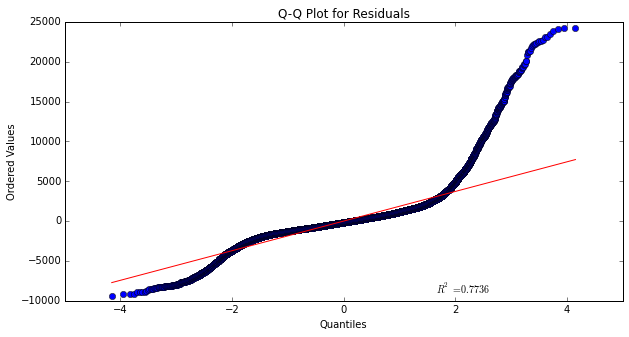

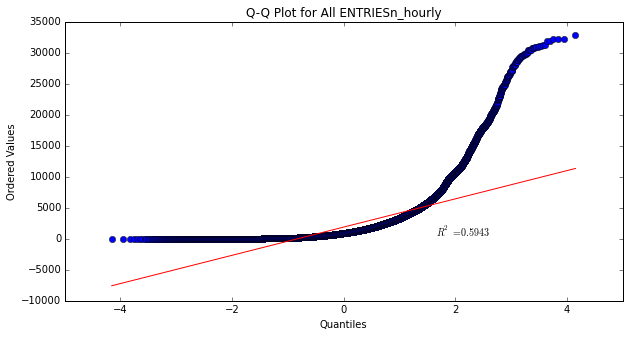

In [394]:
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.title('Q-Q Plot for Residuals')
pylab.show()

stats.probplot(df['ENTRIESn_hourly'], dist="norm", plot=pylab)
pylab.title('Q-Q Plot for All ENTRIESn_hourly')
pylab.show()

In [395]:
'''
Testing how well the linear model performs
http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/
'''
# create a dataframe of the actual, predications and residuals
pd.options.mode.chained_assignment = None
cmpr = df[['UNIT', 'datetime','ENTRIESn_hourly' ]]
cmpr['predictions'] = predictions
cmpr['residuals'] = cmpr['ENTRIESn_hourly'] - cmpr['predictions']
cmpr['residuals_standardized'] = (cmpr['ENTRIESn_hourly'] - cmpr['predictions'])/np.sqrt(cmpr['predictions'])

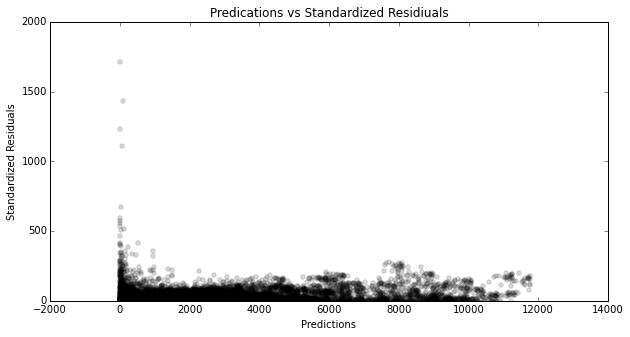

In [397]:
# create a dataframe of the predications and standardized residuals
a = plt.scatter(x=cmpr['predictions'], y=cmpr['residuals_standardized'], color='black', alpha=0.15)
plt.xlabel("Predictions")
plt.ylabel("Standardized Residuals")
plt.title("Predications vs Standardized Residiuals")
plt.ylim(0,2000)
plt.legend()

We have a few large outliers at the 0-500 Predications.  I limited the y-axis so we can see the distribution better.  The plot is clusted around the bottom of the chart and we really can't see any clear pattern.

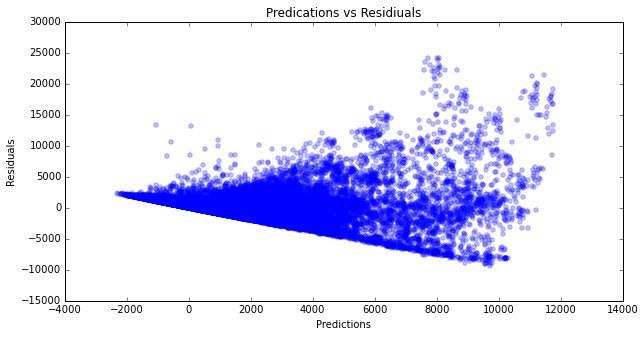

In [398]:
# create a dataframe of the predications and residuals
a = plt.scatter(x=cmpr['predictions'], y=cmpr['residuals'], color='blue', alpha=0.25)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Predications vs Residiuals")
plt.legend()

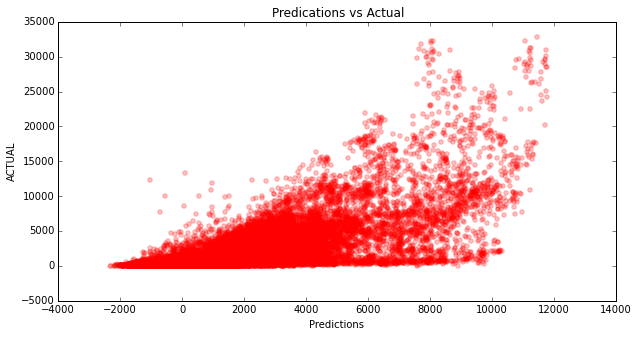

In [399]:
# create a dataframe of the actual, predications and residuals
a = plt.scatter(x=cmpr['predictions'], y=cmpr['ENTRIESn_hourly'], color='red', alpha=0.25)
plt.xlabel("Predictions")
plt.ylabel("ACTUAL")
plt.title("Predications vs Actual")
plt.legend()

Both of the Predications vs. Standardized Residuals and Predications vs. Actual we see this fan shape in the positive direction where as the number or predications increases we have more variabiliy of the Acutal or Residuals.

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.  

Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.



### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

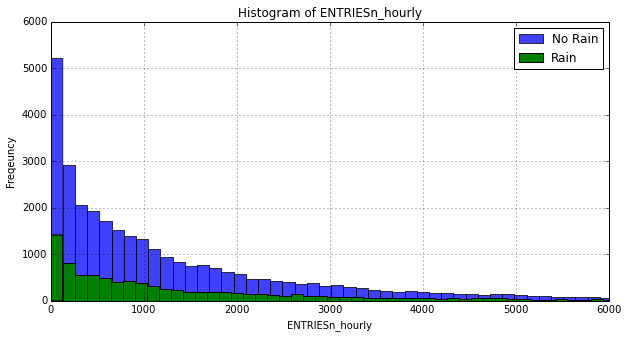

In [400]:
plt.figure()
#bins
binSize = 250
# your code here to plot a historgram for hourly entries when it is not raining
norain['ENTRIESn_hourly'].hist(color='blue', label='No Rain', bins=binSize,alpha=0.75)
# your code here to plot a historgram for hourly entries when it is raining
rain['ENTRIESn_hourly'].hist(color='green',label='Rain',bins=binSize)
plt.legend()
plt.title(r'Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.xlim(0,6000)
plt.ylabel('Freqeuncy')


## 3.2 One visualization can be more freeform. 

You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

In [401]:
# Add the day as interger
def datetime_to_day(string_data):
    d = datetime.datetime.strptime(string_data, '%Y-%m-%d %H:%M:%S')
    return int(d.day)

# Add the hours as an interger
def datetime_to_hour_of_day(string_data):
    #d = datetime.datetime.strptime(string_data, '%Y-%m-%d %H:%M:%S')
    d = datetime.datetime.strptime(string_data, '%H:%M:%S')
    return int(d.hour)

rain['day'] = rain['datetime'].map(datetime_to_day)
rain['iHour'] = rain['TIMEn'].map(datetime_to_hour_of_day)

norain['day'] = norain['datetime'].map(datetime_to_day)
norain['iHour'] = norain['TIMEn'].map(datetime_to_hour_of_day)

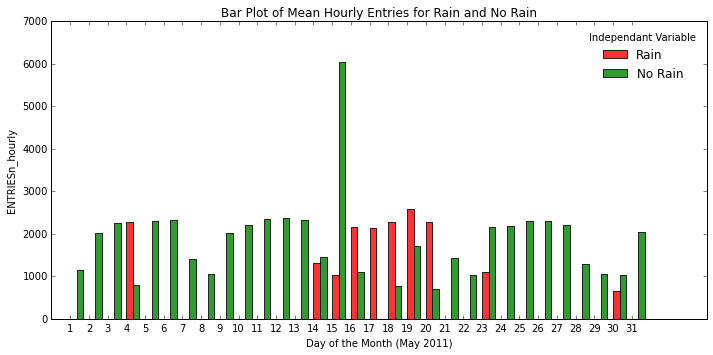

May 2011
Number of Rainy Days: 10
Number of Non-Rainy Days: 30


In [402]:
# note it might not rain the entire day, or it could rain during periods of low activity
tr = rain.groupby('day', as_index=True).mean()
tr = tr.reset_index()

tnr = norain.groupby('day', as_index=True).mean()
tnr =tnr.reset_index()

fig, ax = plt.subplots()
index = array(numpy.arange(1,32))
bar_width = 0.35
opacity = 0.8

p1 = plt.bar(tr['day'], tr['ENTRIESn_hourly'], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Rain')

p2 = plt.bar(tnr['day'] + bar_width, tnr['ENTRIESn_hourly'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='No Rain')

plt.xlabel('Day of the Month (May 2011)')
plt.ylabel('ENTRIESn_hourly')
plt.title('Bar Plot of Mean Hourly Entries for Rain and No Rain')
plt.legend(loc='best', frameon=False, title='Independant Variable')
xticks( index )
plt.tight_layout()
plt.show()

print 'May 2011\nNumber of Rainy Days: %.0f\nNumber of Non-Rainy Days: %.0f' % (len(tr.index), len(tnr.index))

Notice we had overlap where some hours in the day it did not rain.  Rain can occur during any hour of the day for as little as one hour to 24 hours which can affect the hourly entries.

We also have a very large outlier on the 14th for a mean around 6,046 average hourly entries. The 14th was a week end.

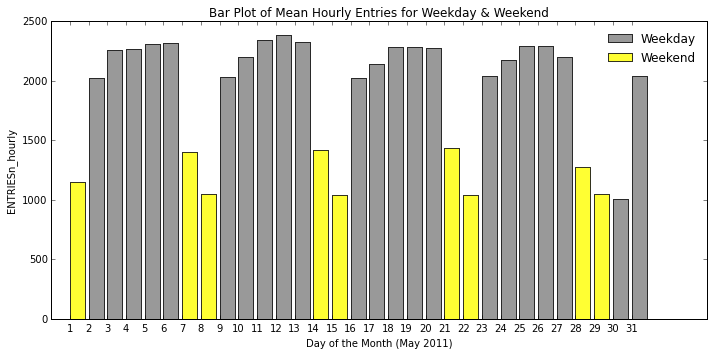

In [415]:
# note it might not rain the entire day, or it could rain during periods of low activity
wd = df[df['weekday']==1]
we = df[df['weekday']==0]

wd['day'] = wd['datetime'].map(datetime_to_day)
we['day'] = we['datetime'].map(datetime_to_day)

wd = wd.groupby('day', as_index=True).mean()
wd = wd.reset_index()

we = we.groupby('day', as_index=True).mean()
we = we.reset_index()

fig, ax = plt.subplots()
index = array(numpy.arange(1,32))
#bar_width = 0.35
opacity = 0.8

p1 = plt.bar(wd['day'], wd['ENTRIESn_hourly'], 
                 alpha=opacity,
                 color='gray',
                 label='Weekday')

p2 = plt.bar(we['day'], we['ENTRIESn_hourly'],
                 alpha=opacity,
                 color='yellow',
                 label='Weekend')

plt.xlabel('Day of the Month (May 2011)')
plt.ylabel('ENTRIESn_hourly')
plt.title('Bar Plot of Mean Hourly Entries for Weekday & Weekend')
plt.legend(loc='best', frameon=False)
xticks( index )
plt.tight_layout()
plt.show()

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

People ride the subway more when it is raining based on the above analysis.

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

####Mann Whitney U test 
The p-value less then the p-critical value in Table 1.0.

u(42647) = 153635120, p < 0.001  
P-Value				 = 0.000005482



#### Welch's t-test
The T-statistic value and p-value both less the t-critical value and p-critical value in Table 2.0.

We Reject the null hypothesis based on the t-test results.

Welch's t-test was run on the data as well as 99% confidence intervals (CI) for the mean difference. It was found during days with rain, the ENTRIESn_hourly (2028.20  ± 3189.43) were significantly higher than the days with No Rain (1845.54 ± 2878.77). 

t(42647) = 5.043, p < 0.005) with a difference of 182.66 (99% CI, 94.46 to 270.85) ENTRIESn_hourly.

Also the **rain coefficient** from the linear regression is a postive value, which means when we have rain the value is 1 the positive value coefficent is multipled by (1), which increases the hourly entry predications.  cond_Mist coefficient was positive as well.  

Review section 2.1 and 2.2 for additional coefficients.

## Section 5. Reflection

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: 

#### Dataset

The	dataset	consisted of one month of subway riders	with hourly	entries. Having	more data than one month would be beneficial. Three	years of data would	provide	a good start to	compare	like days, months, temperature,	rainy days,	and	holidays.  We	should	rethink	the	analysis to	 remove	the	weekend	days from the analysis since the total number of riders for a	weekend	could shift	the	mean.

The dataset is not normally distributed.  We can see from the box plot there are a large amount of outliers in the dataset.


#### Linear	Regression	Model

I think the linear model is	adequate base on the Q-Q plots to caluclate the hourly entries.  Weekends and Holidays have different use patterns, and locations of turnstiles have different use patterns. Some entries and exits may occur without the person being	above ground our outside. (One could ride the rain from Connecticut, exit at Grand Central and then	re-enter the Subway).

With respect to	the linear regression model the ridership of the subway	might find a better fit	with a non-linear model.  This leads us to believe our model is missing a variable or we need to split the data apart and see if we can group stations or turnstyles into more normalized groups.		


#### Statistical	Test

I used the Mann	Whitney	U statistical test,	which works	well for non-normal distributions.  However, “Use only when the	number	of	observation	in each sample is >	20 and you have 2 independent samples of ranks.

I also used the Welch's T-Test which works when there are unequal variances and non-normal distribution.

I'm unsure what it means if more than one statistical test is done. Does using more than one type of statistical test improve the results or just make the results less clear to understand with regards to Mann Whitney vs Welch's T-test since the both seem applicable to this dataset.


### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

May 14-20th was a very rainy set of consectutive days for NYC.

# Referenecs

Python 3.4.2 Documentation     
Retrieved from https://docs.python.org/

ggplot from yhat   
Retrieved from http://ggplot.yhathq.com/

SciPy.org    
Retrieved from http://scipy.org/

Engineering Statistics    
Retrieved from http://www.itl.nist.gov/div898/handbook/

5.2.4.  Are the model residuals well-behaved? [Blog Post]   
Retrieved from http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

The Minitab Blog What Is the Difference between Linear and Nonlinear Equations in Regression Analysis? [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics 

The Minitab Blog Regression Analysis how do I interpret R Squared and assess the goodness of fit. [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

What are the differences between one-tailed and two-tailed tests? [Blog Post]   
Retrieved from http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm

Dummy Variables [Wiki Post]   
Retrieved from http://en.wikipedia.org/wiki/Dummy_variable_(statistics) 

Mann-Whitney U Test using SPSS [Blog Post]   
Retrieved from https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.phpRegression 

Independent T-Test for Two Samples [Blog Post]   
Retrieved from https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Analysis – How to Interpret the Constant Y Intercept [Blog Post]   
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept 

Coding in the Rain [Blog Post]   
Retrieved From http://drjasondavis.com/2013/07/08/coding-in-the-rain/ 

Mann-Whitney U Test using SPSS  
Retrieved From https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php

## Misc. Notes
#### Data Validation
any mising dates  
are all dates valid  
any missing ENTRIESn_hourly  
any missing hours, any hours out of the correct date?  
we have day_week can we use this for the weekend   
do we have folks using more UNITs in other areas more than others...   
what happens on the weekend with the data...  
when it rains does it rain for all hours in the day or just like early in the AM...
what is the hourly entries like throughout the day... 

####  Assumptions for Independent T Test - DOES THIS APPLY TO WELCH"S

> Assumption #1: Your dependent variable should be measured on a continuous scale (i.e., it is measured at the interval or ratio level). Examples of variables that meet this criterion include revision time (measured in hours), intelligence (measured using IQ score), exam performance (measured from 0 to 100), weight (measured in kg), and so forth. You can learn more about continuous variables in our article: Types of Variable.

> Assumption #2: Your independent variable should consist of two categorical, independent groups. Example independent variables that meet this criterion include gender (2 groups: male or female), employment status (2 groups: employed or unemployed), smoker (2 groups: yes or no), and so forth.

> Assumption #3: You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves. For example, there must be different participants in each group with no participant being in more than one group. This is more of a study design issue than something you can test for, but it is an important assumption of the independent t-test. If your study fails this assumption, you will need to use another statistical test instead of the independent t-test (e.g., a paired-samples t-test). If you are unsure whether your study meets this assumption, you can use our Statistical Test Selector, which is part of our enhanced content.

> Assumption 4: There should be no significant outliers. Outliers are simply single data points within your data that do not follow the usual pattern (e.g., in a study of 100 students' IQ scores, where the mean score was 108 with only a small variation between students, one student had a score of 156, which is very unusual, and may even put her in the top 1% of IQ scores globally). 

> The problem with outliers is that they can have a negative effect on the independent t-test, reducing the validity of your results. 

Independent T-Test, Laerd Statistics Blog   
Retrieved From: https://statistics.laerd.com/spss-tutorials/independent-t-test-using-spss-statistics.php